In [3]:
import requests
from PIL import Image
import io
import base64
from IPython.display import display
import pandas as pd
from pathlib import Path
import wikipedia
import urllib.request
import tqdm
import nature_go_client
import matplotlib.pyplot as plt
import sys
import rembg

In [2]:
# Nature Go parameters
NATURE_GO_USERNAME = input()
NATURE_GO_PASSWORD = input()

# Stable Diffusion parameters
SD_HOST = 'http://nature-go.edouardleurent.com'
PROMPT = "{commonNames} {scientificNameWithoutAuthor}, herbarium illustration, 19th century, transactions of the Botanical Society of London"


## Retrieve species with missing images through Nature go API

In [37]:
client = nature_go_client.NatureGoClient(username=NATURE_GO_USERNAME, password=NATURE_GO_PASSWORD)
client.login()

In [24]:
species_list = client.get_labeled_species(illustration=False, limit=5)
print(f'Found {len(species_list)} species')
species_list = pd.DataFrame(species_list)
species_list

,id,scientificNameWithoutAuthor,commonNames,genus,family,gbif_id,powo_id,wikipedia_word_count,number_of_occurrences,occurences_cdf,rarity_gpt,descriptions,illustration,illustration_transparent,reference_image_url,illustration_url,display_name,num_observations_total,num_questions_total
0,2,Alliaria petiolata,"[Garlic Mustard, Jack-by-the-hedge, Hedge-Garl...",Alliaria,Brassicaceae,5376075.0,1176324-2,1167,8788,0.988123,2.0,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Garlic Mustard,0,0
1,3,Crataegus monogyna,"[Hawthorn, Common Hawthorn, Red hawthorn, Engl...",Crataegus,Rosaceae,9220780.0,723820-1,1326,8362,0.982995,4.0,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Hawthorn,0,0
2,4,Cornus sanguinea,"[Common Dogwood, Dogwood, Pegwood, Red dogwood...",Cornus,Cornaceae,3082234.0,271661-1,462,8178,0.977980,3.4,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Common Dogwood,0,0
3,5,Sambucus nigra,"[Common Elder, Black elderberry, Elderberry, C...",Sambucus,Viburnaceae,2888728.0,30122169-2,1091,7923,0.973122,2.0,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Common Elder,0,0
4,6,Achillea millefolium,"[Common yarrow, Yarrow, Milfoil, Blood-wort, N...",Achillea,Asteraceae,3120060.0,2294-2,2344,7917,0.968267,1.4,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Common yarrow,0,0


## Select species

In [25]:
species = species_list.iloc[0]
species

id                                                                             2
scientificNameWithoutAuthor                                   Alliaria petiolata
commonNames                    [Garlic Mustard, Jack-by-the-hedge, Hedge-Garl...
genus                                                                   Alliaria
family                                                              Brassicaceae
gbif_id                                                                5376075.0
powo_id                                                                1176324-2
wikipedia_word_count                                                        1167
number_of_occurrences                                                       8788
occurences_cdf                                                          0.988123
rarity_gpt                                                                   2.0
descriptions                                                                  []
illustration                

## Get a reference image

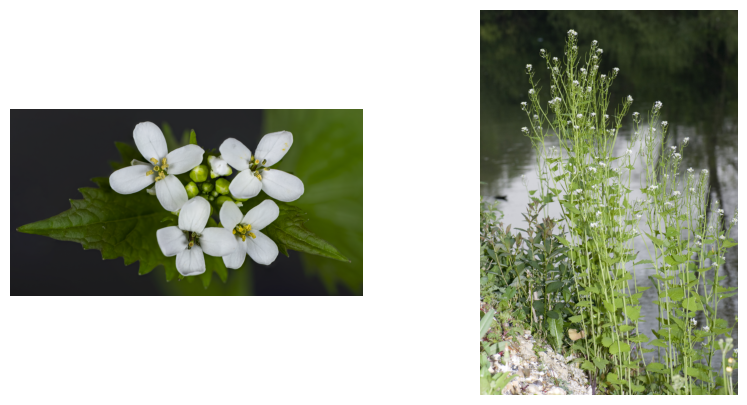

In [34]:
def download_image(url):
    with urllib.request.urlopen(url) as url:
        img = Image.open(io.BytesIO(url.read()))
        return img

def fetch_wikipedia_images(scientific_name):
    page = wikipedia.page(scientific_name)
    return page.images[:2]
    
    
def display_images(*images):
    _, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5), squeeze=False)
    for i, image in enumerate(images):
        axes.flat[i].imshow(image)
        axes.flat[i].axis('off')


reference_images_url = fetch_wikipedia_images(species.scientificNameWithoutAuthor)
reference_images = [download_image(img) for img in reference_images_url]
display_images(*reference_images)

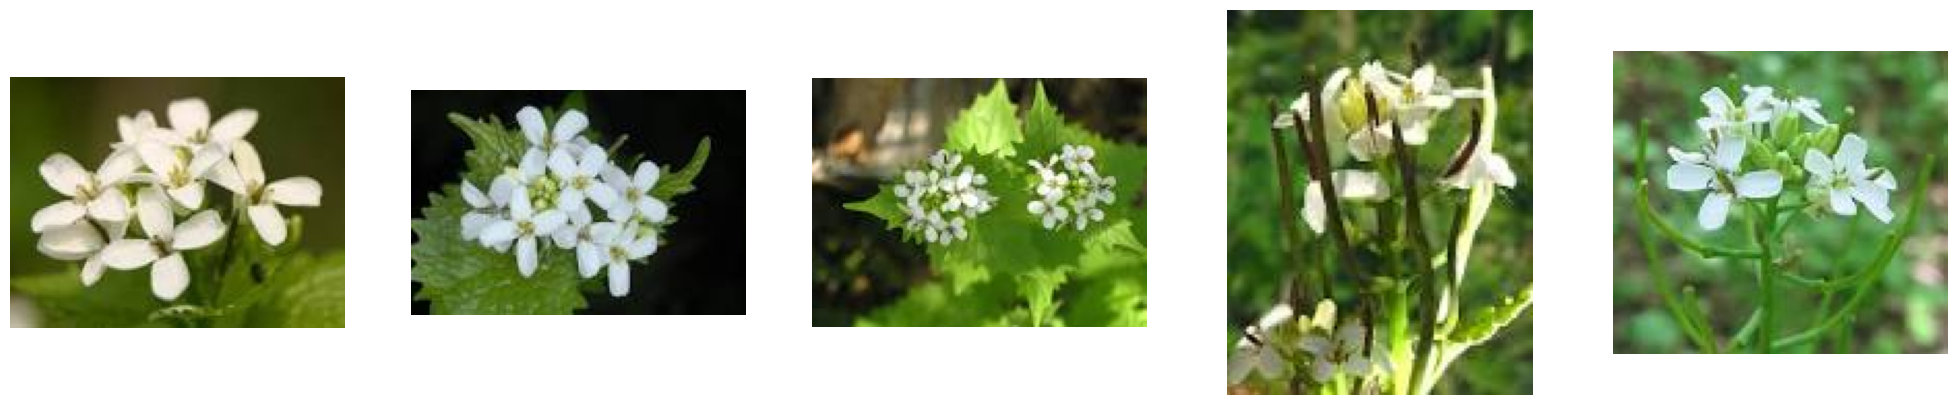

In [28]:
import requests
from bs4 import BeautifulSoup

def google_image_search(query):
  url = "https://www.google.com/search?q={}&source=lnms&tbm=isch".format(query)
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  image_elements = soup.find_all("img", class_="DS1iW")
  return [i['src'] for i in image_elements][:5]

# reference_images_url = google_image_search(f'{species.scientificNameWithoutAuthor} + flower')
# reference_images = list(map(download_image, reference_images_url))
# display_images(*reference_images)


## Run generation with ComfyUI

In [29]:
# Import workflows
sys.argv = ['']
from illustration_workflows import txt2img_workflow
from illustration_workflows import controlnet_workflow
comfyui_path = txt2img_workflow.find_path("ComfyUI")
rembg_session = rembg.new_session(model_name="isnet-general-use")


def run_txt2img_worflow(positive_prompt, negative_prompt):
    import random
    random.seed(len(positive_prompt))
    result = txt2img_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

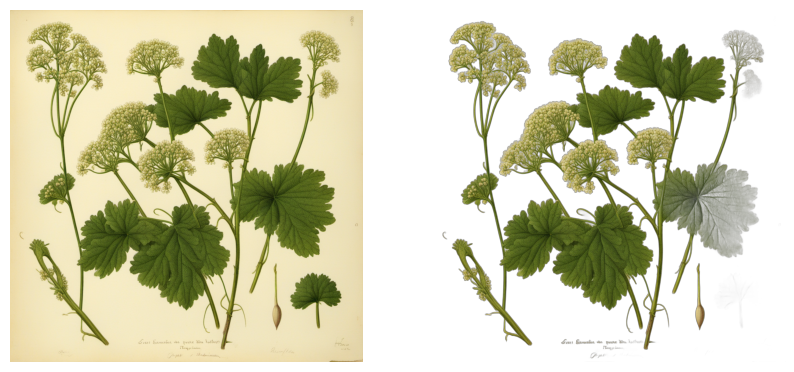

In [33]:
prompt = PROMPT.format(commonNames=', '.join(species.commonNames[:3]), scientificNameWithoutAuthor=species.scientificNameWithoutAuthor)
print(prompt)
illustration, illustration_transparent = run_txt2img_worflow(positive_prompt=prompt, negative_prompt='')
display_images(illustration, illustration_transparent)

  0%|          | 0/20 [00:00<?, ?it/s]

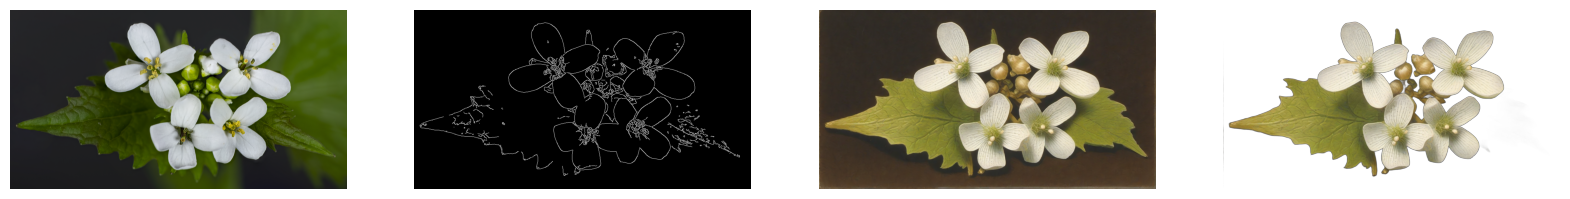

In [35]:
reference_image = reference_images[0]
reference_image_name = f"reference_{species.scientificNameWithoutAuthor}.png"
reference_image.save(Path(comfyui_path) / "input" / reference_image_name)

def run_controlnet_worflow(positive_prompt, negative_prompt, reference_image_name):
    import random
    random.seed(len(positive_prompt))
    result = controlnet_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt, control_image=reference_image_name)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    mask = Image.open(Path(comfyui_path) / 'output' / result['controlnet_mask']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent, mask

reference_illustration, reference_illustration_transparent, mask = run_controlnet_worflow(positive_prompt=prompt, negative_prompt='black and white', reference_image_name=reference_image_name)
display_images(reference_image, mask, reference_illustration, reference_illustration_transparent)

In [32]:
print(reference_image.size)
print(reference_illustration.size)

## Upload result to Nature Go API

In [ ]:
confirm_send = input()
if confirm_send == 'y':
    client.update_species_image(species_id=species.id, image=illustration, image_name='illustration')
    client.update_species_image(species_id=species.id, image=illustration_transparent, image_name='illustration_transparent')
    client.update_species_image(species_id=species.id, image=reference_illustration, image_name='reference_illustration')
    client.update_species_image(species_id=species.id, image=reference_illustration_transparent, image_name='reference_illustration_transparent')
    client.update_species_field(species_id=species.id, key='reference_image_url', value=reference_images_url[0])

 y
